# <font color='blue'/> **Import and prepare data**

In [ ]:
!pip install -q keras==2.4.0
!pip install -q tensorflow==2.4.0

In [ ]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install opencv-python-headless==4.1.2.30
!pip install cellpose
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf
!pip install -q numpy==1.20.0
!pip install -q imgaug==0.3.0

In [ ]:
!git clone https://github.com/leekunhee/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.83 MiB | 35.21 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [ ]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

# Target image dimension which are divisable by 64 as required by the Mask-RCNN model
HEIGHT_TARGET = 64 * 9  # = 576
WIDTH_TARGET = 64 * 11  # = 704
SHAPE_TARGET = (HEIGHT_TARGET, WIDTH_TARGET)

In [ ]:
import sys
sys.path.append('./Mask_RCNN')

In [ ]:
import matplotlib.pyplot as plt
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import visualize
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from cellpose import models, io, plot

import os
import sys
import json
import time
import skimage
import imageio
import glob
import multiprocessing
import cv2
import imgaug.augmenters as iaa
import imgaug as ia
import tifffile
import tqdm

Using TensorFlow backend.


In [ ]:
!unzip ./drive/MyDrive/sartorius/dataset/fold_0.zip

In [ ]:
!unzip ./drive/MyDrive/sartorius/dataset/sartorius-cell-instance-segmentation.zip -d ./sartorius-dataset

In [ ]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask_0_depth(truth,SHAPE), rles_to_mask_0_depth(pred,SHAPE)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

In [ ]:
# Removes the padding from an image
def unpad_image(image):
    offset_h = (HEIGHT_TARGET - HEIGHT) // 2
    offset_w = (WIDTH_TARGET - WIDTH) // 2
    
    return image[offset_h:offset_h+HEIGHT, offset_w:offset_w+WIDTH]

# Func. to pad images and masks
def pad_image(image, constant_values):
    pad_h = (HEIGHT_TARGET - HEIGHT) // 2
    pad_w = (WIDTH_TARGET - WIDTH) // 2
    
    if len(image.shape) == 3:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), constant_values=constant_values)
    else:
        return np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), constant_values=constant_values)

# Run Length Encode an instance
def rle_encode(img, unpad=True):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    img = unpad_image(img) if unpad else img
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
  
def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8) # binary mask
    return np.any(np.sum(msk, axis=-1)>1) # only one channgel will contain value

def rles_to_mask_0_depth(encs, shape=SHAPE):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

def rles_to_mask_N_depth(encs, shape=SHAPE):
    # Image shape
    mask = np.full(shape=[len(encs), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, row in enumerate(encs):
        s = row.split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(encs), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

In [ ]:
val_files = np.sort(glob.glob('./val/*img.tif'))

# <font color='blue'/> **Mask RCNN**

In [ ]:
!mkdir ./model_checkpoints

In [ ]:
class InferenceConfig(Config):
    
    NAME = 'sartorius-cell'
    
    # Set batch size to 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # No. classes
    NUM_CLASSES = 4
    
    # Image dimensions
    IMAGE_RESIZE_MODE = "none"
    IMAGE_MIN_DIM = HEIGHT_TARGET
    IMAGE_MAX_DIM = WIDTH_TARGET
    IMAGE_SHAPE = [HEIGHT_TARGET, WIDTH_TARGET, 3]
    
    # Mini mask
    USE_MINI_MASK = False
    
    # Dataloader Queue Size (was set to 100 but resulted in OOM error)
    MAX_QUEUE_SIZE = 10
    
    # Regions of Interest
    PRE_NMS_LIMIT = 6000
    
    # Non Max Supression
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    
    # Instances
    MAX_GT_INSTANCES = 790
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 400

infer_config = InferenceConfig()

In [ ]:
mrcnn_model = modellib.MaskRCNN(mode="inference", config=infer_config, model_dir='./model_checkpoints')
mrcnn_model.load_weights('./drive/MyDrive/sartorius/weights/mask_rcnn_l2reg-and-head_0010.h5', by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
img_names, pred_annots = [], []

for f in tqdm(val_files):
  img_name, pred_annot = [], []
  img_id = f.split('/')[-1].split('_')[0]

  # Load image
  img = tifffile.imread(f)
  img = pad_image(img, 128)
  img = np.stack([img, img, img], axis=-1)

  # Detect
  r = mrcnn_model.detect([img])[0]
  pred_masks = r['masks']

  if pred_masks.shape[-1] == 0:
    img_name.append(img_id)
    pred_annot.append('')
  else:
    if check_overlap(pred_masks):
      #print('Overlap found!!!')
      pred_masks = fix_overlap(pred_masks)
    for i in range(pred_masks.shape[-1]):
      pred_mask = pred_masks[..., i].astype(np.uint8)
      img_name.append(img_id)
      pred_annot.append(rle_encode(pred_mask))
    
  img_names.extend(img_name)
  pred_annots.extend(pred_annot)

  0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
pd.DataFrame({'id': img_names, 'predicted': pred_annots}).sort_values(['id']).to_csv('mrcnn_val.csv', index=False)

# <font color='blue'/> **Cellpose**

In [ ]:
cellpose_path = './drive/MyDrive/sartorius/weights/cellpose_250622_concat_epoch_500'
cellpose_model = models.CellposeModel(gpu=True, pretrained_model=cellpose_path, 
                                      concatenation=True)

In [ ]:
sz_model = models.SizeModel(cp_model=cellpose_model, 
                            pretrained_size='./drive/MyDrive/sartorius/weights/cellpose_1700_size_100.npy')

In [ ]:
print('Load model from: ', cellpose_path)

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#test_files = glob.glob('./val/*_img.tif')
print(len(val_files))
#model = models.CellposeModel(gpu=True, pretrained_model=model_path)

ids, masks = [],[]
for fn in tqdm(val_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    pred_diam,_ = sz_model.eval(io.imread(fn), channels=[0, 0])
    preds, flows, _ = cellpose_model.eval(io.imread(fn), diameter=pred_diam, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
        
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('cellpose_val.csv', index=False)

Load model from:  ./drive/MyDrive/sartorius/weights/cellpose_250622_concat_epoch_500
121


  0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
train_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

mrcnn_df = pd.read_csv('./mrcnn_val.csv')
mrcnn_df = mrcnn_df.groupby('id').predicted.agg(list).reset_index()

df = pd.merge(train_df, mrcnn_df, on='id')

In [ ]:
annotations = df.annotation.values
predictions = df.predicted.values

In [ ]:
# Check iou MRCNN
print('MRCNN')
iou_map(annotations, predictions, verbose=1)

MRCNN


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(394, 214)
Thresh	TP	FP	FN	Prec.
0.500	6264	1835	8317	0.382
0.550	5839	2260	8742	0.347
0.600	5333	2766	9248	0.307
0.650	4671	3428	9910	0.259
0.700	3851	4248	10730	0.205
0.750	2750	5349	11831	0.138
0.800	1616	6483	12965	0.077
0.850	657	7442	13924	0.030
0.900	113	7986	14468	0.005
0.950	2	8097	14579	0.000
AP	-	-	-	0.175


0.17492477177908267

In [ ]:
train_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_df = pd.read_csv('./cellpose_val.csv')
cellpose_df = cellpose_df.groupby('id').predicted.agg(list).reset_index()

df = pd.merge(train_df, cellpose_df, on='id')

In [ ]:
annotations = df.annotation.values
predictions = df.predicted.values

In [ ]:
# Check iou Cellpose
print('Cellpose')
iou_map(annotations, predictions, verbose=1)

Cellpose


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(394, 183)
Thresh	TP	FP	FN	Prec.
0.500	4975	1274	9606	0.314
0.550	4647	1602	9934	0.287
0.600	4256	1993	10325	0.257
0.650	3729	2520	10852	0.218
0.700	2995	3254	11586	0.168
0.750	2031	4218	12550	0.108
0.800	1063	5186	13518	0.054
0.850	379	5870	14202	0.019
0.900	49	6200	14532	0.002
0.950	2	6247	14579	0.000
AP	-	-	-	0.143


0.14265079279827525

**MRCNN**

In [ ]:
train_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

mrcnn_pred = pd.read_csv('mrcnn_val.csv')
mrcnn_pred = mrcnn_pred.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,mrcnn_pred,on='id')

print(df.shape)

df.head()

(121, 3)


,id,annotation,predicted
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,[350582 7 351285 9 351988 11 352692 11 353395 ...
1,04cd81dfb245,[286968 5 287672 9 288376 11 289081 12 289787 ...,[259885 2 267620 1 271834 2 272538 2 273241 3 ...
2,085eb8fec206,[15779 2 16481 5 17185 5 17889 6 18593 7 19297...,[215355 10 216056 13 216759 15 217462 16 21816...
3,0c90b86742b2,[388 12 1091 13 1795 13 2498 13 3202 13 3905 1...,[75762 1 76465 1 77110 2 77168 2 77813 6 77868...
4,0cfdeeb0dded,[352146 3 352849 7 353552 9 354255 10 354959 1...,[141616 7 142318 9 143020 11 143723 12 144427 ...


In [ ]:
sartorius_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
id_with_cell = sartorius_df.groupby('id').first()['cell_type']

In [ ]:
val_id_with_cell = id_with_cell[id_with_cell.index.isin(df['id'])]

In [ ]:
val_id_with_cell = pd.DataFrame({'id': val_id_with_cell.index, 'cell_type': val_id_with_cell.values})

In [ ]:
val_df = df.merge(val_id_with_cell, how='inner', on='id')

In [ ]:
mrcnn_astro_val_df = val_df[val_df['cell_type'] == 'astro'].reset_index()
mrcnn_cort_val_df = val_df[val_df['cell_type'] == 'cort'].reset_index()
mrcnn_shsy5y_val_df = val_df[val_df['cell_type'] == 'shsy5y'].reset_index()

In [ ]:
print('MRCNN Astro Analysis:')

astro_annotations = mrcnn_astro_val_df.annotation.values
astro_predictions = mrcnn_astro_val_df.predicted.values

iou_map(astro_annotations, astro_predictions, verbose=1)

MRCNN Astro Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(64, 50)
Thresh	TP	FP	FN	Prec.
0.500	850	374	1271	0.341
0.550	762	462	1359	0.295
0.600	660	564	1461	0.246
0.650	532	692	1589	0.189
0.700	414	810	1707	0.141
0.750	272	952	1849	0.089
0.800	142	1082	1979	0.044
0.850	40	1184	2081	0.012
0.900	5	1219	2116	0.001
0.950	0	1224	2121	0.000
AP	-	-	-	0.136


0.13583140519557518

In [ ]:
print('Cort Analysis:')

cort_annotations = mrcnn_cort_val_df.annotation.values
cort_predictions = mrcnn_cort_val_df.predicted.values

iou_map(cort_annotations, cort_predictions, verbose=1)

Cort Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(32, 32)
Thresh	TP	FP	FN	Prec.
0.500	1703	352	253	0.738
0.550	1676	379	280	0.718
0.600	1636	419	320	0.689
0.650	1554	501	402	0.632
0.700	1440	615	516	0.560
0.750	1235	820	721	0.445
0.800	896	1159	1060	0.288
0.850	466	1589	1490	0.131
0.900	96	1959	1860	0.025
0.950	2	2053	1954	0.000
AP	-	-	-	0.423


0.42260532664720873

In [ ]:
print('Shsy5y Analysis:')

shsy5y_annotations = mrcnn_shsy5y_val_df.annotation.values
shsy5y_predictions = mrcnn_shsy5y_val_df.predicted.values

iou_map(shsy5y_annotations, shsy5y_predictions, verbose=1)

Shsy5y Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(394, 214)
Thresh	TP	FP	FN	Prec.
0.500	3711	1109	6793	0.320
0.550	3401	1419	7103	0.285
0.600	3037	1783	7467	0.247
0.650	2585	2235	7919	0.203
0.700	1997	2823	8507	0.150
0.750	1243	3577	9261	0.088
0.800	578	4242	9926	0.039
0.850	151	4669	10353	0.010
0.900	12	4808	10492	0.001
0.950	0	4820	10504	0.000
AP	-	-	-	0.134


0.13429484610608017

**Cellpose**

In [ ]:
train_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cp_pred = pd.read_csv('cellpose_val.csv')
cp_pred = cp_pred.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cp_pred,on='id')

print(df.shape)

df.head()

(121, 3)


,id,annotation,predicted
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,[157 8 859 12 1562 13 2265 14 2968 16 3671 17 ...
1,04cd81dfb245,[286968 5 287672 9 288376 11 289081 12 289787 ...,[3 14 706 16 1409 18 2113 18 2817 18 3521 19 4...
2,085eb8fec206,[15779 2 16481 5 17185 5 17889 6 18593 7 19297...,[625 22 1327 30 2031 31 2735 31 3440 31 4144 3...
3,0c90b86742b2,[388 12 1091 13 1795 13 2498 13 3202 13 3905 1...,[135 12 839 13 1544 13 2248 14 2953 14 3657 15...
4,0cfdeeb0dded,[352146 3 352849 7 353552 9 354255 10 354959 1...,[25082 6 25784 10 26487 13 27190 14 27894 15 2...


In [ ]:
sartorius_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')
id_with_cell = sartorius_df.groupby('id').first()['cell_type']

val_id_with_cell = id_with_cell[id_with_cell.index.isin(df['id'])]
val_id_with_cell = pd.DataFrame({'id': val_id_with_cell.index, 'cell_type': val_id_with_cell.values})

val_df = df.merge(val_id_with_cell, how='inner', on='id')

In [ ]:
cp_astro_val_df = val_df[val_df['cell_type'] == 'astro'].reset_index()
cp_cort_val_df = val_df[val_df['cell_type'] == 'cort'].reset_index()
cp_shsy5y_val_df = val_df[val_df['cell_type'] == 'shsy5y'].reset_index()

In [ ]:
print('Cellpose Astro Analysis:')

astro_annotations = cp_astro_val_df.annotation.values
astro_predictions = cp_astro_val_df.predicted.values

iou_map(astro_annotations, astro_predictions, verbose=1)

Cellpose Astro Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(64, 20)
Thresh	TP	FP	FN	Prec.
0.500	412	122	1709	0.184
0.550	381	153	1740	0.168
0.600	334	200	1787	0.144
0.650	297	237	1824	0.126
0.700	240	294	1881	0.099
0.750	167	367	1954	0.067
0.800	83	451	2038	0.032
0.850	23	511	2098	0.009
0.900	8	526	2113	0.003
0.950	0	534	2121	0.000
AP	-	-	-	0.083


0.08316189967026696

In [ ]:
print('Cellpose Cort Analysis:')

cort_annotations = cp_cort_val_df.annotation.values
cort_predictions = cp_cort_val_df.predicted.values

iou_map(cort_annotations, cort_predictions, verbose=1)

Cellpose Cort Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(32, 31)
Thresh	TP	FP	FN	Prec.
0.500	1343	181	613	0.628
0.550	1304	220	652	0.599
0.600	1236	288	720	0.551
0.650	1119	405	837	0.474
0.700	942	582	1014	0.371
0.750	709	815	1247	0.256
0.800	459	1065	1497	0.152
0.850	206	1318	1750	0.063
0.900	33	1491	1923	0.010
0.950	1	1523	1955	0.000
AP	-	-	-	0.310


0.31042097628965076

In [ ]:
print('Cellpose Shsy5y Analysis:')

shsy5y_annotations = cp_shsy5y_val_df.annotation.values
shsy5y_predictions = cp_shsy5y_val_df.predicted.values

iou_map(shsy5y_annotations, shsy5y_predictions, verbose=1)

Cellpose Shsy5y Analysis:


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(394, 183)
Thresh	TP	FP	FN	Prec.
0.500	3220	971	7284	0.281
0.550	2962	1229	7542	0.252
0.600	2686	1505	7818	0.224
0.650	2313	1878	8191	0.187
0.700	1813	2378	8691	0.141
0.750	1155	3036	9349	0.085
0.800	521	3670	9983	0.037
0.850	150	4041	10354	0.010
0.900	8	4183	10496	0.001
0.950	1	4190	10503	0.000
AP	-	-	-	0.122


0.1217254226004656

In [ ]:
y = np.array([0.175, 0.143, 0.136, 0.423, 0.134, 0.083, 0.310, 0.122]) * 100
x = ['Tất cả', 'Tất cả', 'Astro', 'Cort', 'Shsy5y', 'Astro', 'Cort', 'Shsy5y']
hue = ['Mask RCNN', 'Cellpose', 'Mask RCNN', 'Mask RCNN', 'Mask RCNN', 'Cellpose', 'Cellpose', 'Cellpose']

In [ ]:
ap_analysis = pd.DataFrame({'Cell type': x, 'Score': y, 'Model': hue})

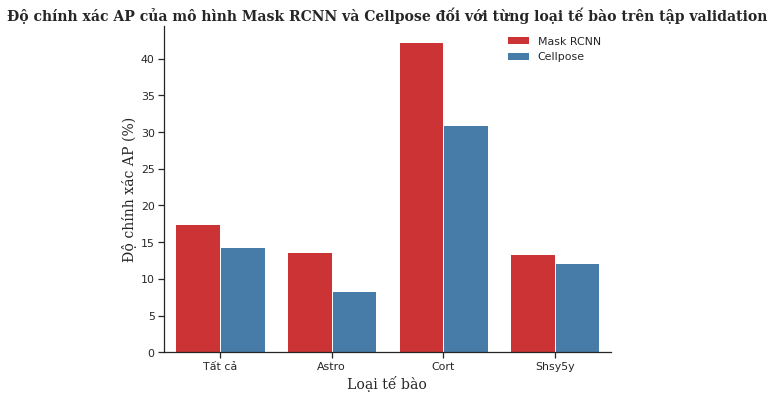

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))
axs = plt.subplot(1, 1, 1)

sns.despine()
sns.set_theme(palette='Set1')
sns.set_style('ticks')

sns.barplot(data=ap_analysis, x='Cell type', y='Score', hue='Model')

axs.set_xlabel('Loại tế bào', fontdict={'family': 'serif', 'size': 14})
axs.set_ylabel('Độ chính xác AP (%)', fontdict={'family': 'serif', 'size': 14})
axs.set_title('Độ chính xác AP của mô hình Mask RCNN và Cellpose đối với từng loại tế bào trên tập validation',
              fontdict={'family': 'serif', 'size': 14, 'weight': 'bold'})
leg = axs.get_legend()
leg.set_title('')
leg.set_frame_on(False)

## <font color='gold'/> **Visualize**

**Astro**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


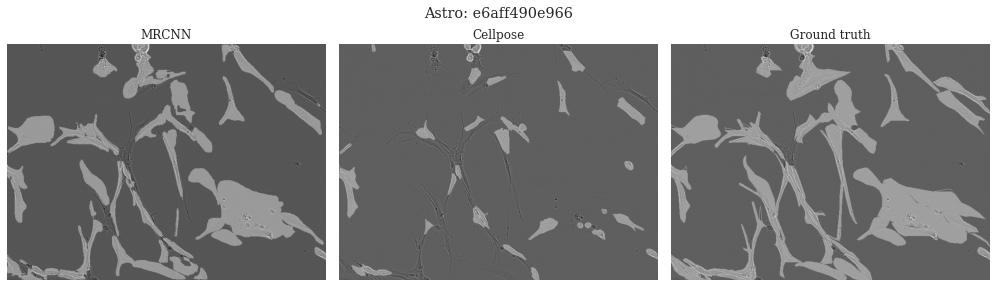

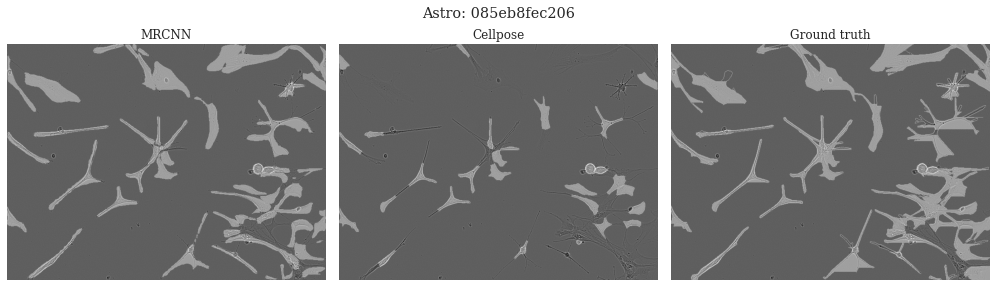

In [ ]:
mrcnn_pred_df = pd.read_csv('./drive/MyDrive/sartorius/mrcnn_val.csv')
cp_pred_df = pd.read_csv('./drive/MyDrive/sartorius/cellpose_val.csv')
sartorius_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')

for i in range(2):
  img_id = np.random.choice(val_id_with_cell[val_id_with_cell['cell_type'] == 'astro'].id)
  img_file = './val/{}_img.tif'.format(img_id)
  img = tifffile.imread(img_file)

  mrcnn_rles = mrcnn_pred_df[mrcnn_pred_df['id'] == img_id]['predicted'].values
  cp_rles = cp_pred_df[cp_pred_df['id'] == img_id]['predicted'].values
  gt_rles = sartorius_df.loc[sartorius_df['id'] == img_id, 'annotation'].values

  mrcnn_mask, cp_mask = rles_to_mask_N_depth(mrcnn_rles), rles_to_mask_0_depth(cp_rles)

  mrcnn_merged = cv2.addWeighted(img, 0.75, 
                               np.clip(np.sum(mrcnn_mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  cellpose_merged = cv2.addWeighted(img, 0.75, 
                                  np.clip(cp_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  gt_mask = rles_to_mask_0_depth(gt_rles)
  gt_merged = cv2.addWeighted(img, 0.75, 
                           np.clip(gt_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  _, axs = plt.subplots(1, 3, figsize=(14, 4.5))


  axs[0].imshow(mrcnn_merged, cmap='gray')
  axs[0].axis('off')
  axs[0].set_title('MRCNN', fontdict={'family': 'serif', 'size': 12})
  axs[1].imshow(cellpose_merged, cmap='gray')
  axs[1].axis('off')
  axs[1].set_title('Cellpose', fontdict={'family': 'serif', 'size': 12})
  axs[2].imshow(gt_merged, cmap='gray')
  axs[2].axis('off')
  axs[2].set_title('Ground truth', fontdict={'family': 'serif', 'size': 12})

  plt.tight_layout()
  plt.suptitle('Astro: ' + img_id, fontdict={'family': 'serif', 'size': 13, 'weight': 'bold'})
  plt.show()

**Cort**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


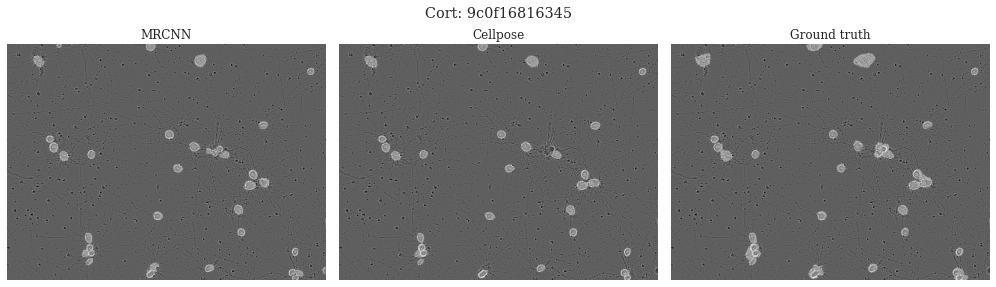

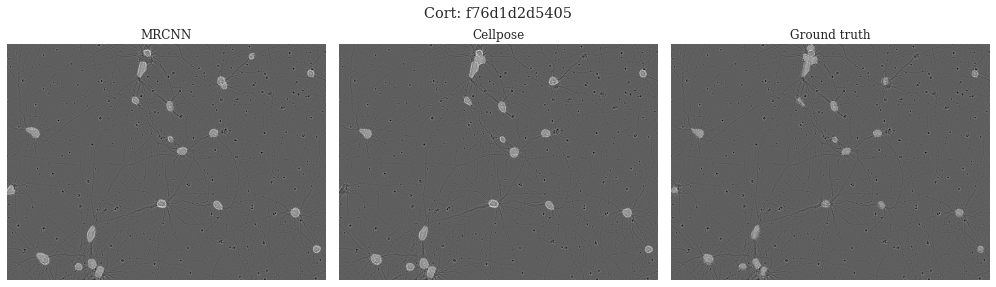

In [ ]:
mrcnn_pred_df = pd.read_csv('./drive/MyDrive/sartorius/mrcnn_val.csv')
cp_pred_df = pd.read_csv('./drive/MyDrive/sartorius/cellpose_val.csv')
sartorius_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')

for i in range(2):
  img_id = np.random.choice(val_id_with_cell[val_id_with_cell['cell_type'] == 'cort'].id)
  img_file = './val/{}_img.tif'.format(img_id)
  img = tifffile.imread(img_file)

  mrcnn_rles = mrcnn_pred_df[mrcnn_pred_df['id'] == img_id]['predicted'].values
  cp_rles = cp_pred_df[cp_pred_df['id'] == img_id]['predicted'].values
  gt_rles = sartorius_df.loc[sartorius_df['id'] == img_id, 'annotation'].values

  mrcnn_mask, cp_mask = rles_to_mask_N_depth(mrcnn_rles), rles_to_mask_0_depth(cp_rles)

  mrcnn_merged = cv2.addWeighted(img, 0.75, 
                               np.clip(np.sum(mrcnn_mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  cellpose_merged = cv2.addWeighted(img, 0.75, 
                                  np.clip(cp_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  gt_mask = rles_to_mask_0_depth(gt_rles)
  gt_merged = cv2.addWeighted(img, 0.75, 
                           np.clip(gt_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  _, axs = plt.subplots(1, 3, figsize=(14, 4.5))


  axs[0].imshow(mrcnn_merged, cmap='gray')
  axs[0].axis('off')
  axs[0].set_title('MRCNN', fontdict={'family': 'serif', 'size': 12})
  axs[1].imshow(cellpose_merged, cmap='gray')
  axs[1].axis('off')
  axs[1].set_title('Cellpose', fontdict={'family': 'serif', 'size': 12})
  axs[2].imshow(gt_merged, cmap='gray')
  axs[2].axis('off')
  axs[2].set_title('Ground truth', fontdict={'family': 'serif', 'size': 12})

  plt.tight_layout()
  plt.suptitle('Cort: ' + img_id, fontdict={'family': 'serif', 'size': 13, 'weight': 'bold'})
  plt.show()

**Shsy5y**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


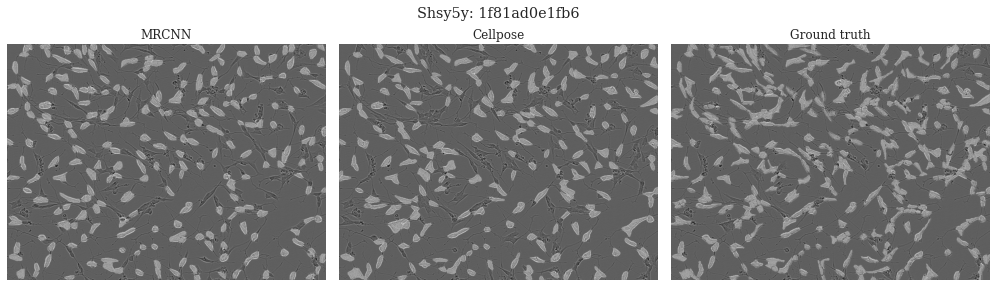

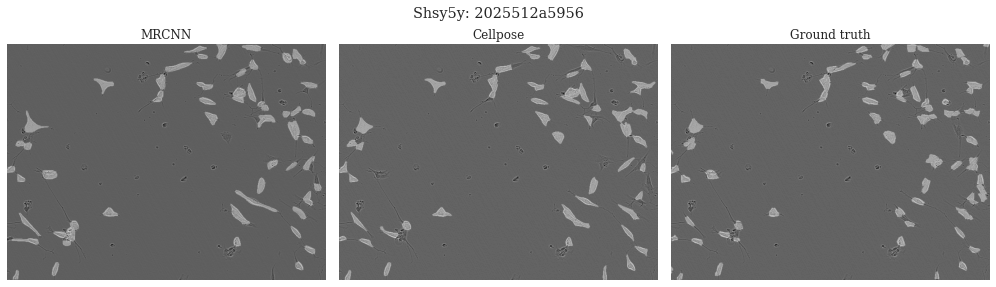

In [ ]:
mrcnn_pred_df = pd.read_csv('./drive/MyDrive/sartorius/mrcnn_val.csv')
cp_pred_df = pd.read_csv('./drive/MyDrive/sartorius/cellpose_val.csv')
sartorius_df = pd.read_csv('./sartorius-dataset/sartorius-cell-instance-segmentation/train.csv')

for i in range(2):
  img_id = np.random.choice(val_id_with_cell[val_id_with_cell['cell_type'] == 'shsy5y'].id)
  img_file = './val/{}_img.tif'.format(img_id)
  img = tifffile.imread(img_file)

  mrcnn_rles = mrcnn_pred_df[mrcnn_pred_df['id'] == img_id]['predicted'].values
  cp_rles = cp_pred_df[cp_pred_df['id'] == img_id]['predicted'].values
  gt_rles = sartorius_df.loc[sartorius_df['id'] == img_id, 'annotation'].values

  mrcnn_mask, cp_mask = rles_to_mask_N_depth(mrcnn_rles), rles_to_mask_0_depth(cp_rles)

  mrcnn_merged = cv2.addWeighted(img, 0.75, 
                               np.clip(np.sum(mrcnn_mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  cellpose_merged = cv2.addWeighted(img, 0.75, 
                                  np.clip(cp_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  gt_mask = rles_to_mask_0_depth(gt_rles)
  gt_merged = cv2.addWeighted(img, 0.75, 
                           np.clip(gt_mask.astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

  _, axs = plt.subplots(1, 3, figsize=(14, 4.5))


  axs[0].imshow(mrcnn_merged, cmap='gray')
  axs[0].axis('off')
  axs[0].set_title('MRCNN', fontdict={'family': 'serif', 'size': 12})
  axs[1].imshow(cellpose_merged, cmap='gray')
  axs[1].axis('off')
  axs[1].set_title('Cellpose', fontdict={'family': 'serif', 'size': 12})
  axs[2].imshow(gt_merged, cmap='gray')
  axs[2].axis('off')
  axs[2].set_title('Ground truth', fontdict={'family': 'serif', 'size': 12})

  plt.tight_layout()
  plt.suptitle('Shsy5y: ' + img_id, fontdict={'family': 'serif', 'size': 13, 'weight': 'bold'})
  plt.show()

In [ ]:
print(len(cp_astro_val_df))
print(len(cp_cort_val_df))
print(len(cp_shsy5y_val_df))

28
62
31
